<a href="https://colab.research.google.com/github/sushankindroji/Agro-market/blob/main/Agro_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Farmer1 trying to add a lot
----------Lot Created----------
Lot ID :  1
Farmer2 trying to add a lot
----------Lot Created----------
Lot ID :  2
Government verifies the lots at the mandi.
Enter the weight in quintals for lot 1: 20
Moisture (% by wt) : 11
Immature and shriveled grains (% by wt) : 3
Foreign Matter (% by wt) : 0.1
Damaged grains/Discoloured grains (% by wt) : 5
Enter the weight in quintals for lot 2: 30
Moisture (% by wt) : 13
Immature and shriveled grains (% by wt) : 5
Foreign Matter (% by wt) : 0.5
Damaged grains/Discoloured grains (% by wt) : 6
Government starts auction, traders can start bidding.
Trader1 wants to see lots for bidding
+----+----------+-------------+-----------------------+--------------------------------+-----------+-------------+
|    |   Lot ID | Commodity   |   Weight(in quintals) |   Last bided price per quintal | Region    | Farmer      |
+====+==========+=============+=======================+================================+===========+===========

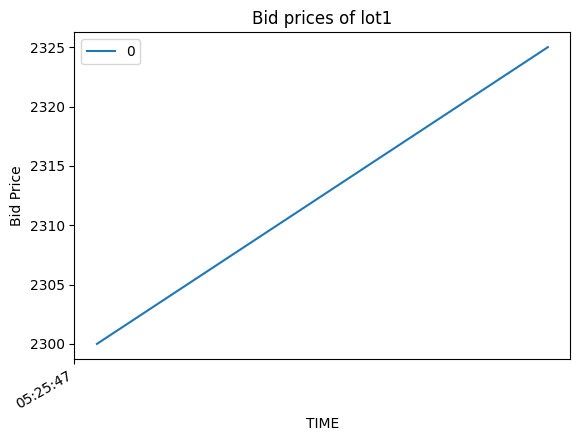

Government ends auction
Trader1 checks his bidding status.
+----+----------+------------------+--------------+----------------------------------+
|    |   Lot ID | Lot Status       | Buyer Name   |   Last bided price (per quintal) |
+====+==========+==================+==============+==================================+
|  0 |        1 | Bidding Declared | P.Anjaiah    |                             2325 |
+----+----------+------------------+--------------+----------------------------------+
Farmer1 checks the status of his lot.
Lot Status : Bidding Declared
Farmer1 wants to give consent.
+----+----------+-------------+-----------------------+---------------------+--------------+
|    |   Lot ID | Commodity   |   Weight(in quintals) |   Price per quintal | Buyer Name   |
+====+==========+=============+=======================+=====================+==============+
|  0 |        1 | Wheat       |                    20 |                2325 | P.Anjaiah    |
+----+----------+-------------+----

In [ ]:
1
#project
import sqlite3
from tabulate import tabulate
import pandas as pd
import datetime
import matplotlib.pyplot as plt
#class Government
conn= sqlite3.connect('Agro_Market.db')
cursor =conn.cursor()
cursor.execute("CREATE TABLE IF NOT EXISTS Farmer(name TEXT,farmer_id   PRIMARY KEY,acres REAL,region TEXT,phone_number INTEGER)")
cursor.execute("CREATE TABLE IF NOT EXISTS Buyer(name TEXT,buyer_id  PRIMARY KEY,phone_number INTEGER)")
cursor.execute("CREATE TABLE IF NOT EXISTS Lot(id  INTEGER PRIMARY KEY,farmer VARCHAR(128),status TEXT,grain_name TEXT,quantity INTEGER,quality TEXT,buyer VARCHAR(128),last_bid_price INTEGER)")
cursor.execute("CREATE TABLE IF NOT EXISTS Invoice(invoice_number PRIMARY KEY,creation_date VARCHAR(128),creation_time VARCHAR(128),lot INTEGER,payment TEXT ,buyer VARCHAR(128))")
cursor.execute("CREATE TABLE IF NOT EXISTS Bidding(bid_time VARCHAR(128) PRIMARY KEY,lot INTEGER,buyer_id VARCHAR(128) ,bid_price INTEGER )")
conn.commit()


class Government:
  farmers={}
  buyers={}
  unverified_lots={}
  verified_lots={}
  lots_bidded={}
  MSP_data=pd.DataFrame({'Wheat':[2275,2000,1850],'Paddy':[2000,1850,1600],"Jowar":[3180,3010,2895]},index=["A","B","C"])

  lot_id_counter=1

  def generate_lot_id() :
    lot_id=Government.lot_id_counter
    Government.lot_id_counter+=1
    return lot_id

  def verify_lot(lot_id) :
    try :
      lot=Government.unverified_lots[lot_id]
      quantity=float(input("Enter the weight in quintals for lot {}: ".format(lot_id)) ) #what if type error?
      lot.quantity=quantity
      lot.quality=Government.determine_quality()
      if lot.quality=="D" :
        lot.status="Unapproved"
      else :
        lot.status="Approved"
        Government.verified_lots[lot_id]=lot
        lot.last_bid_price=Government.MSP_data.at[lot.quality,lot.name]
        conn.execute("UPDATE Lot SET quantity = (?),quality = (?),status = ? ,last_bid_price = ? WHERE id = ? ",(quantity,lot.quality,lot.status,lot.last_bid_price,lot_id))
        conn.commit()
      del Government.unverified_lots[lot_id]
    except KeyError :
      print("Invalid ID .No lot with this ID for verification.")
    except ValueError :
      print("Invalid weight.Should enter numeric value. ")

  def start_bidding() :
    for lot in Government.verified_lots.values() :
      lot.status="On Bidding"
      conn.execute("UPDATE Lot SET status = ?  WHERE id = ? ",(lot.status,lot.lot_id))
      conn.commit()

  def end_bidding() :
      if len([lot for lot in Government.verified_lots.values() if lot.status == "On Bidding" ])==0:
        print("No Lots On Bidding")
      else :
        lot_id_list=list(Government.verified_lots.keys())
        for lot_id in lot_id_list:
          lot=Government.verified_lots[lot_id]
          if lot.status == "On Bidding" :
            lot.status="Bidding Declared"
            conn.execute("UPDATE Lot SET status = ?  WHERE id = ? ",(lot.status,lot_id))
            conn.commit()
            lot.farmer.lots_for_consent[lot.lot_id]=lot
            Government.lots_bidded[lot.lot_id]=lot
            del Government.verified_lots[lot_id]
#what if no one bidded ?buyer is None
  @staticmethod
  def determine_quality() :
    moisture = float(input("Moisture (% by wt) : "))
    immature_and_shriveled_grains = float(input("Immature and shriveled grains (% by wt) : "))
    foreign_matter = float(input("Foreign Matter (% by wt) : "))
    damaged_grains = float(input("Damaged grains/Discoloured grains (% by wt) : "))
    if 10 < moisture <= 12 and immature_and_shriveled_grains <= 4 and foreign_matter <= 0.1 and damaged_grains <= 5:
      return "A"
    elif 12 < moisture <= 14 and 4 < immature_and_shriveled_grains <= 6 and 0.1 < foreign_matter <= 0.6 and 5 < damaged_grains <= 7:
      return "B"
    elif 14 < moisture <= 16 and 6 < immature_and_shriveled_grains <= 8 and 0.6 < foreign_matter <= 1 and 7 < damaged_grains <= 10:
      return "C"
    else:
      return "D"

#class Lot
class Lot :
  def __init__(self,farmer,grain_name,quantity) :
    self.farmer=farmer
    self.name=grain_name
    self.quantity=quantity
    self.status="Unverified"
    self.quality=None
    self.lot_id=Government.generate_lot_id()
    Government.unverified_lots[self.lot_id]=self
    self.last_bid_price=None
    self.buyer=None
    self.region=self.farmer.region
    self.price_data=pd.DataFrame()
    cursor.execute("INSERT OR IGNORE INTO Lot(id ,farmer ,status ,grain_name  ) VALUES (?,?,?,?)",(self.lot_id,farmer.farmer_id,self.status,grain_name))
    conn.commit()
  def show_price_plot(self) :
    self.price_data.reindex(columns =["Bid Price"])
    self.price_data.plot()
    plt.xlabel("TIME")
    plt.ylabel("Bid Price")
    plt.title(f"Bid prices of lot{self.lot_id}")

    plt.show()

class Farmer:
  def __init__(self,name,farmer_id,acres,region,phone_number):
    self.name=name
    self.farmer_id=farmer_id
    Government.farmers[farmer_id]=self
    self.phone_number=phone_number #validate phone no ?
    self.acres=acres
    self.region=region
    self.lots={}
    self.lots_for_consent={}
    self.lots_traded=[]
    cursor.execute("INSERT OR IGNORE INTO Farmer(name ,farmer_id ,acres , region,phone_number ) VALUES (?,?,?,?,?)",(name,farmer_id,acres,region,phone_number))
    conn.commit()
  def add_lot(self,grain_name,quantity) :
    lot=Lot(self,grain_name,quantity)
    self.lots[lot.lot_id]=lot
    print("----------Lot Created----------")
    print("Lot ID : ",lot.lot_id)
    #print any other detail ?

  def consent(self,lot_id) :
    if lot_id in self.lots_for_consent :
      lot=self.lots_for_consent[lot_id]
      print(tabulate([[lot.lot_id,lot.name,lot.quantity,lot.last_bid_price,lot.buyer.name]],headers=["Lot ID","Commodity","Weight(in quintals)","Price per quintal","Buyer Name"],tablefmt="grid", showindex="always"))
      #print seller contact no ?
      consent=input("Do you consent the lot? (Yes/No): ")
      if consent.lower() == "yes" :
        lot.status+=",Consent Given"
        del self.lots_for_consent[lot_id]
        self.lots_traded.append(lot)
        lot.buyer.invoices.append(Invoice(lot,lot.buyer))#what govt should do
      elif consent.lower() == "no" :
        lot.status += ",No Consent "
        del self.lots_for_consent[lot_id]
        Government.unverified_lots[lot_id]=lot #adding as a new lot again .
      conn.execute("UPDATE Lot SET status = ?  WHERE id = ? ",(lot.status,lot_id))
      conn.commit()
    else :
      print("Invalid ID.No such lot for consent.")

  def traded_lots(self) :
    print(tabulate( [[lot.lot_id,lot.name,lot.quantity,lot.last_bid_price,lot.buyer.name]for lot in self.lots_traded] ,headers=["Lot ID","Commodity","Weight(in quintals)","Price per quintal","Buyer Name"],tablefmt="grid", showindex="always"))
    #do we need date ?

  def lot_status(self,lot_id) :
    print("Lot Status :",self.lots[lot_id].status)
    #any other detail ?

#class Buyer
class Buyer :
  def __init__(self,buyer_id,name,phone_number) : #id to be given by govt ,how ?
    self.buyer_id=buyer_id
    self.name=name
    self.phone_number=phone_number
    self.bidded_lots={}
    Government.buyers[buyer_id]=self
    self.invoices=[]
    cursor.execute("INSERT OR IGNORE INTO Buyer(name ,buyer_id ,phone_number ) VALUES (?,?,?)",(name,buyer_id,phone_number))
    conn.commit()

  def bank_details(self,account_name,bank_name,account_number) :
    self.account_name=account_name
    self.bank_name=bank_name
    self.account_number=account_number

  def commodity_list(self) :
    print(tabulate([[lot.lot_id,lot.name,lot.quantity,lot.last_bid_price,lot.region,lot.farmer.name]for lot in Government.verified_lots.values() if lot.status=="On Bidding"]  ,headers=["Lot ID","Commodity","Weight(in quintals)","Last bided price per quintal","Region","Farmer"],tablefmt="grid", showindex="always"))

  def lot_price_data(self,lot_id) :
    if lot_id in Government.verified_lots :
      lot=Government.verified_lots[lot_id]
      lot.show_price_plot()

  def new_bid(self,lot_id,bid_price) :
    if lot_id in Government.verified_lots :
      lot=Government.verified_lots[lot_id]
      if bid_price >lot.last_bid_price :
        lot.last_bid_price=bid_price
        lot.buyer=self
        self.bidded_lots[lot_id]=lot
        bid_time =datetime.datetime.now()
        lot.price_data=pd.concat( [lot.price_data,pd.Series([ bid_price ],index=[bid_time])] )
        conn.execute("UPDATE Lot SET last_bid_price = ?,buyer = ? WHERE id = ? ",(lot.last_bid_price,lot.buyer.buyer_id,lot_id))
        conn.execute("INSERT INTO Bidding(bid_time ,lot,buyer_id  ,bid_price ) VALUES (?,?,?,?)",(bid_time,lot_id,self.buyer_id,bid_price))
        conn.commit()
      else :
        print("Given price is below its current bid price.")
    else :
      print("Invalid lot ID.No such Lot for bidding.")


  def bid_status(self) :
    print(tabulate([[lot.lot_id,lot.status,lot.buyer.name,lot.last_bid_price] for lot in self.bidded_lots.values()]  ,headers=["Lot ID","Lot Status","Buyer Name","Last bided price (per quintal)"],tablefmt="grid", showindex="always"))

  def pending_invoices(self) :
    for invoice in self.invoices :
      if invoice.payment=="Pending" :
        invoice.print_invoice()

  def bid_history(self) :
     print( tabulate( [[lot.lot_id,lot.name,lot.quantity,lot.last_bid_price,lot.farmer.name] for lot in self.bidded_lots.values() if lot.buyer.name==self.name ]  ,headers=["Lot ID","Grain","Quantity","price (per quintal)","Farmer"],tablefmt="grid", showindex="always" ))


#class Invoice
class Invoice :
  def __init__(self,lot,buyer) :
    self.invoice_number="IN"+str(lot.lot_id)#any other better way?
    self.creation_date=datetime.date.today()
    self.creation_time=datetime.datetime.now().strftime("%H:%M:%S")
    self.lot=lot
    self.payment="Pending"
    self.payor = buyer
    conn.execute("INSERT INTO Invoice(invoice_number,creation_date,creation_time ,lot ,payment ,buyer) VALUES(?,?,?,?,?,?) ",(self.invoice_number,self.creation_date,self.creation_time ,self.lot.lot_id ,self.payment ,self.payor.buyer_id))


  def print_invoice(self) :
    print("------------------------------------")
    print("Invoice Number :",self.invoice_number)
    print("Date :",self.creation_date)
    print("Time :",self.creation_time)
    print("Lot code :",self.lot.lot_id)
    print("Farmer name :",self.lot.farmer.name)
    print("Payor name :",self.payor.name)
    print("Invoice amount :",self.lot.last_bid_price*self.lot.quantity)
    print("Farmer Ph No :",self.lot.farmer.phone_number)
    print("Bidded time ,price(per quintal) :\n ",self.lot.price_data.tail(1))
    #bank details
  def pay_invoice(self) :
    pass

#class Insurance
class Insurance:
  def __init__(self):
    user=input("farmer or merchant")
    type_calamities=input(" floods or droughts")
    if user=="farmer":
      self.total_quantity=int(input("total acres damaged"))
      self.upload_landdoucments=input("upload documents id")
    else:
      self.total_quantity=int(input("enter the quantity damaged"))
      self.upload_invoice=input("upolad invoice ")
  def verification(self,verification_code):
    self.verification_code=verification_code
    if self.verification_code==True:
      print("verification done by govt guide and eligible for insurance")
      amount=self.total_quantity*1000
      print("amount of insurance claimed is :",amount)

    else:
      print("Verification done by govt guide and not eligible for insurance")
def main():
    # Creating farmers
    farmer1 = Farmer("Govardhan", "TS014f001", 500, "Hyderabad", "8978792348")
    farmer2 = Farmer("V Mallesham", "TS005f0001", 500, "Nalgonda", "8978792388")

    # Creating traders
    trader1 = Buyer("TS014t0028", "Nataraj", "8937472832")
    trader2 = Buyer("TS014t0008", "P.Anjaiah", "8937474732")

    # Adding lots
    print("Farmer1 trying to add a lot")
    farmer1.add_lot("Wheat", 20)
    print("Farmer2 trying to add a lot")
    farmer2.add_lot("Jowar", 30)

    # Verifying lots
    print("Government verifies the lots at the mandi.")
    Government.verify_lot(1)
    Government.verify_lot(2)

    # Starting auction
    print("Government starts auction, traders can start bidding.")
    Government.start_bidding()

    # Traders checking lots for bidding
    print("Trader1 wants to see lots for bidding")
    trader1.commodity_list()
    print("Trader1 wants to bid on any one of the lot")
    trader1.new_bid(1, 2300)
    print("Trader2 wants to see lots for bidding")
    trader2.commodity_list()
    print("Trader2 wants to bid on any one of the lot")
    trader2.new_bid(1, 2325)
    trader2.lot_price_data(1)

    # Ending auction
    print("Government ends auction")
    Government.end_bidding()

    # Checking bidding status
    print("Trader1 checks his bidding status.")
    trader1.bid_status()

    # Checking lot status
    print("Farmer1 checks the status of his lot.")
    farmer1.lot_status(1)

    # Giving consent
    print("Farmer1 wants to give consent.")
    farmer1.consent(1)

    # Checking pending invoices
    print("Trader2 checks pending invoices")
    trader2.pending_invoices()

if __name__ == "__main__":
    main()

conn.close()




WELCOME TO AGRO MARKET 

_________________________

WELCOME TO AGRO MARKET 

1-Government,2-Farmer,3-Trader,4-Exit. 
choose the appropriate number : 2
1-Log In,2-Sign up 
Choose any option  :2
Name :Ramarao
Id :127
Phone Number :7867567890
Land in acres :40
Region/address :Medak

WELCOME TO AGRO MARKET 

1-Government,2-Farmer,3-Trader,4-Exit. 
choose the appropriate number : 2
1-Log In,2-Sign up 
Choose any option  :1
Enter your ID :127
1-Add Lot,2-Give consent,3-See Traded Lots,4-Check lot status,5-Log Out.
Choose any option  :1
Enter Grain Name(Wheat,Paddy,Jowar) :Wheat
Enter the Quantity :30
----------Lot Created----------
Lot ID :  1
1-Add Lot,2-Give consent,3-See Traded Lots,4-Check lot status,5-Log Out.
Choose any option  :5
Logged out successfully. 

WELCOME TO AGRO MARKET 

1-Government,2-Farmer,3-Trader,4-Exit. 
choose the appropriate number : 1
1-Verify Lot,2-start_bidding,3-end_biddiing,4-Log Out.
Choose any option  :1
Enter Lot ID : 1
Enter the weight in quintals for lot 1

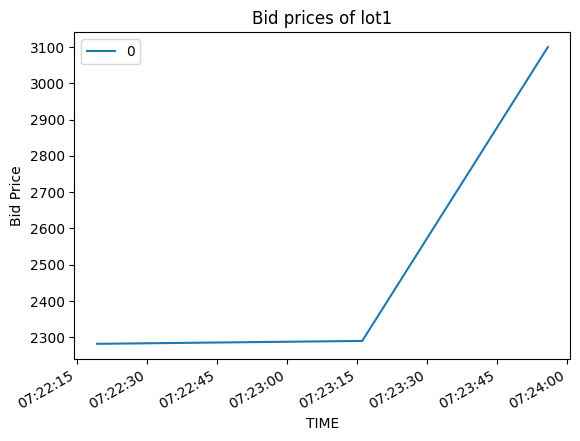

1-Update bank details,2-See lots for bidding,3-Bid a lot,
4-Check bid status,5-Pending Invoices,6-Lots traded,7-check bid price data,8-Log OUt
Choose any option  :8
Logged out successfully. 

WELCOME TO AGRO MARKET 

1-Government,2-Farmer,3-Trader,4-Exit. 
choose the appropriate number : 1
1-Verify Lot,2-start_bidding,3-end_biddiing,4-Log Out.
Choose any option  :3
1-Verify Lot,2-start_bidding,3-end_biddiing,4-Log Out.
Choose any option  :4
Logged out successfully. 

WELCOME TO AGRO MARKET 

1-Government,2-Farmer,3-Trader,4-Exit. 
choose the appropriate number : 2
1-Log In,2-Sign up 
Choose any option  :1
Enter your ID :127
1-Add Lot,2-Give consent,3-See Traded Lots,4-Check lot status,5-Log Out.
Choose any option  :2
Enter Lot ID : 1
+----+----------+-------------+-----------------------+---------------------+--------------+
|    |   Lot ID | Commodity   |   Weight(in quintals) |   Price per quintal | Buyer Name   |
+====+==========+=============+=======================+===============

In [ ]:

#project
import sqlite3
from tabulate import tabulate
import pandas as pd
import datetime
import matplotlib.pyplot as plt
#class Government
conn= sqlite3.connect('Agro_Market.db')
cursor =conn.cursor()
cursor.execute("CREATE TABLE IF NOT EXISTS Farmer(name TEXT,farmer_id   PRIMARY KEY,acres REAL,region TEXT,phone_number INTEGER)")
cursor.execute("CREATE TABLE IF NOT EXISTS Buyer(name TEXT,buyer_id  PRIMARY KEY,phone_number INTEGER)")
cursor.execute("CREATE TABLE IF NOT EXISTS Lot(id  INTEGER PRIMARY KEY,farmer VARCHAR(128),status TEXT,grain_name TEXT,quantity INTEGER,quality TEXT,buyer VARCHAR(128),last_bid_price INTEGER)")
cursor.execute("CREATE TABLE IF NOT EXISTS Invoice(invoice_number PRIMARY KEY,creation_date VARCHAR(128),creation_time VARCHAR(128),lot INTEGER,payment TEXT ,buyer VARCHAR(128))")
cursor.execute("CREATE TABLE IF NOT EXISTS Bidding(bid_time VARCHAR(128) PRIMARY KEY,lot INTEGER,buyer_id VARCHAR(128) ,bid_price INTEGER )")
conn.commit()


class Government:
  farmers={}
  buyers={}
  unverified_lots={}
  verified_lots={}
  lots_bidded={}
  MSP_data=pd.DataFrame({'Wheat':[2275,2000,1850],'Paddy':[2000,1850,1600],"Jowar":[3180,3010,2895]},index=["A","B","C"])

  lot_id_counter=1

  def generate_lot_id() :
    lot_id=Government.lot_id_counter
    Government.lot_id_counter+=1
    return lot_id

  def verify_lot(lot_id) :
    try :
      lot=Government.unverified_lots[lot_id]
      quantity=float(input("Enter the weight in quintals for lot {}: ".format(lot_id)) ) #what if type error?
      lot.quantity=quantity
      lot.quality=Government.determine_quality()
      if lot.quality=="D" :
        lot.status="Unapproved"
      else :
        lot.status="Approved"
        Government.verified_lots[lot_id]=lot
        lot.last_bid_price=Government.MSP_data.at[lot.quality,lot.name]
        conn.execute("UPDATE Lot SET quantity = (?),quality = (?),status = ? ,last_bid_price = ? WHERE id = ? ",(quantity,lot.quality,lot.status,lot.last_bid_price,lot_id))
        conn.commit()
      del Government.unverified_lots[lot_id]
    except KeyError :
      print("Invalid ID .No lot with this ID for verification.")
    except ValueError :
      print("Invalid weight.Should enter numeric value. ")

  def start_bidding() :
    for lot in Government.verified_lots.values() :
      lot.status="On Bidding"
      conn.execute("UPDATE Lot SET status = ?  WHERE id = ? ",(lot.status,lot.lot_id))
      conn.commit()

  def end_bidding() :
      if len([lot for lot in Government.verified_lots.values() if lot.status == "On Bidding" ])==0:
        print("No Lots On Bidding")
      else :
        lot_id_list=list(Government.verified_lots.keys())
        for lot_id in lot_id_list:
          lot=Government.verified_lots[lot_id]
          if lot.status == "On Bidding" :
            lot.status="Bidding Declared"
            conn.execute("UPDATE Lot SET status = ?  WHERE id = ? ",(lot.status,lot_id))
            conn.commit()
            lot.farmer.lots_for_consent[lot.lot_id]=lot
            Government.lots_bidded[lot.lot_id]=lot
            del Government.verified_lots[lot_id]
#what if no one bidded ?buyer is None
  @staticmethod
  def determine_quality() :
    moisture = float(input("Moisture (% by wt) : "))
    immature_and_shriveled_grains = float(input("Immature and shriveled grains (% by wt) : "))
    foreign_matter = float(input("Foreign Matter (% by wt) : "))
    damaged_grains = float(input("Damaged grains/Discoloured grains (% by wt) : "))
    if 10 < moisture <= 12 and immature_and_shriveled_grains <= 4 and foreign_matter <= 0.1 and damaged_grains <= 5:
      return "A"
    elif 12 < moisture <= 14 and 4 < immature_and_shriveled_grains <= 6 and 0.1 < foreign_matter <= 0.6 and 5 < damaged_grains <= 7:
      return "B"
    elif 14 < moisture <= 16 and 6 < immature_and_shriveled_grains <= 8 and 0.6 < foreign_matter <= 1 and 7 < damaged_grains <= 10:
      return "C"
    else:
      return "D"

#class Lot
class Lot :
  def __init__(self,farmer,grain_name,quantity) :
    self.farmer=farmer
    self.name=grain_name
    self.quantity=quantity
    self.status="Unverified"
    self.quality=None
    self.lot_id=Government.generate_lot_id()
    Government.unverified_lots[self.lot_id]=self
    self.last_bid_price=None
    self.buyer=None
    self.region=self.farmer.region
    self.price_data=pd.DataFrame()
    cursor.execute("INSERT OR IGNORE INTO Lot(id ,farmer ,status ,grain_name  ) VALUES (?,?,?,?)",(self.lot_id,farmer.farmer_id,self.status,grain_name))
    conn.commit()
  def show_price_plot(self) :
    self.price_data.reindex(columns =["Bid Price"])
    self.price_data.plot()
    plt.xlabel("TIME")
    plt.ylabel("Bid Price")
    plt.title(f"Bid prices of lot{self.lot_id}")

    plt.show()

class Farmer:
  def __init__(self,name,farmer_id,acres,region,phone_number):
    self.name=name
    self.farmer_id=farmer_id
    Government.farmers[farmer_id]=self
    self.phone_number=phone_number #validate phone no ?
    self.acres=acres
    self.region=region
    self.lots={}
    self.lots_for_consent={}
    self.lots_traded=[]
    cursor.execute("INSERT OR IGNORE INTO Farmer(name ,farmer_id ,acres , region,phone_number ) VALUES (?,?,?,?,?)",(name,farmer_id,acres,region,phone_number))
    conn.commit()
  def add_lot(self,grain_name,quantity) :
    lot=Lot(self,grain_name,quantity)
    self.lots[lot.lot_id]=lot
    print("----------Lot Created----------")
    print("Lot ID : ",lot.lot_id)
    #print any other detail ?

  def consent(self,lot_id) :
    if lot_id in self.lots_for_consent :
      lot=self.lots_for_consent[lot_id]
      print(tabulate([[lot.lot_id,lot.name,lot.quantity,lot.last_bid_price,lot.buyer.name]],headers=["Lot ID","Commodity","Weight(in quintals)","Price per quintal","Buyer Name"],tablefmt="grid", showindex="always"))
      #print seller contact no ?
      consent=input("Do you consent the lot? (Yes/No): ")
      if consent.lower() == "yes" :
        lot.status+=",Consent Given"
        del self.lots_for_consent[lot_id]
        self.lots_traded.append(lot)
        lot.buyer.invoices.append(Invoice(lot,lot.buyer))#what govt should do
      elif consent.lower() == "no" :
        lot.status += ",No Consent "
        del self.lots_for_consent[lot_id]
        Government.unverified_lots[lot_id]=lot #adding as a new lot again .
      conn.execute("UPDATE Lot SET status = ?  WHERE id = ? ",(lot.status,lot_id))
      conn.commit()
    else :
      print("Invalid ID.No such lot for consent.")

  def traded_lots(self) :
    print(tabulate( [[lot.lot_id,lot.name,lot.quantity,lot.last_bid_price,lot.buyer.name]for lot in self.lots_traded] ,headers=["Lot ID","Commodity","Weight(in quintals)","Price per quintal","Buyer Name"],tablefmt="grid", showindex="always"))
    #do we need date ?

  def lot_status(self,lot_id) :
    print("Lot Status :",self.lots[lot_id].status)
    #any other detail ?

#class Buyer
class Buyer :
  def __init__(self,buyer_id,name,phone_number) : #id to be given by govt ,how ?
    self.buyer_id=buyer_id
    self.name=name
    self.phone_number=phone_number
    self.bidded_lots={}
    Government.buyers[buyer_id]=self
    self.invoices=[]
    cursor.execute("INSERT OR IGNORE INTO Buyer(name ,buyer_id ,phone_number ) VALUES (?,?,?)",(name,buyer_id,phone_number))
    conn.commit()

  def bank_details(self,account_name,bank_name,account_number) :
    self.account_name=account_name
    self.bank_name=bank_name
    self.account_number=account_number

  def commodity_list(self) :
    print(tabulate([[lot.lot_id,lot.name,lot.quantity,lot.last_bid_price,lot.region,lot.farmer.name]for lot in Government.verified_lots.values() if lot.status=="On Bidding"]  ,headers=["Lot ID","Commodity","Weight(in quintals)","Last bided price per quintal","Region","Farmer"],tablefmt="grid", showindex="always"))

  def lot_price_data(self,lot_id) :
    if lot_id in Government.verified_lots :
      lot=Government.verified_lots[lot_id]
      lot.show_price_plot()

  def new_bid(self,lot_id,bid_price) :
    if lot_id in Government.verified_lots :
      lot=Government.verified_lots[lot_id]
      if bid_price >lot.last_bid_price :
        lot.last_bid_price=bid_price
        lot.buyer=self
        self.bidded_lots[lot_id]=lot
        bid_time =datetime.datetime.now()
        lot.price_data=pd.concat( [lot.price_data,pd.Series([ bid_price ],index=[bid_time])] )
        conn.execute("UPDATE Lot SET last_bid_price = ?,buyer = ? WHERE id = ? ",(lot.last_bid_price,lot.buyer.buyer_id,lot_id))
        conn.execute("INSERT INTO Bidding(bid_time ,lot,buyer_id  ,bid_price ) VALUES (?,?,?,?)",(bid_time,lot_id,self.buyer_id,bid_price))
        conn.commit()
      else :
        print("Given price is below its current bid price.")
    else :
      print("Invalid lot ID.No such Lot for bidding.")


  def bid_status(self) :
    print(tabulate([[lot.lot_id,lot.status,lot.buyer.name,lot.last_bid_price] for lot in self.bidded_lots.values()]  ,headers=["Lot ID","Lot Status","Buyer Name","Last bided price (per quintal)"],tablefmt="grid", showindex="always"))

  def pending_invoices(self) :
    for invoice in self.invoices :
      if invoice.payment=="Pending" :
        invoice.print_invoice()

  def bid_history(self) :
     print( tabulate( [[lot.lot_id,lot.name,lot.quantity,lot.last_bid_price,lot.farmer.name] for lot in self.bidded_lots.values() if lot.buyer.name==self.name ]  ,headers=["Lot ID","Grain","Quantity","price (per quintal)","Farmer"],tablefmt="grid", showindex="always" ))


#class Invoice
class Invoice :
  def __init__(self,lot,buyer) :
    self.invoice_number="IN"+str(lot.lot_id)#any other better way?
    self.creation_date=datetime.date.today()
    self.creation_time=datetime.datetime.now().strftime("%H:%M:%S")
    self.lot=lot
    self.payment="Pending"
    self.payor = buyer
    conn.execute("INSERT INTO Invoice(invoice_number,creation_date,creation_time ,lot ,payment ,buyer) VALUES(?,?,?,?,?,?) ",(self.invoice_number,self.creation_date,self.creation_time ,self.lot.lot_id ,self.payment ,self.payor.buyer_id))


  def print_invoice(self) :
    print("------------------------------------")
    print("Invoice Number :",self.invoice_number)
    print("Date :",self.creation_date)
    print("Time :",self.creation_time)
    print("Lot code :",self.lot.lot_id)
    print("Farmer name :",self.lot.farmer.name)
    print("Payor name :",self.payor.name)
    print("Invoice amount :",self.lot.last_bid_price*self.lot.quantity)
    print("Farmer Ph No :",self.lot.farmer.phone_number)
    print("Bidded time ,price(per quintal) :\n ",self.lot.price_data.tail(1))
    #bank details
  def pay_invoice(self) :
    pass

#class Insurance
class Insurance:
  def __init__(self):
    user=input("farmer or merchant")
    type_calamities=input(" floods or droughts")
    if user=="farmer":
      self.total_quantity=int(input("total acres damaged"))
      self.upload_landdoucments=input("upload documents id")
    else:
      self.total_quantity=int(input("enter the quantity damaged"))
      self.upload_invoice=input("upolad invoice ")
  def verification(self,verification_code):
    self.verification_code=verification_code
    if self.verification_code==True:
      print("verification done by govt guide and eligible for insurance")
      amount=self.total_quantity*1000
      print("amount of insurance claimed is :",amount)

    else:
      print("Verification done by govt guide and not eligible for insurance")
#user interface code
print("\nWELCOME TO AGRO MARKET \n")
print("_________________________")
while True :
  print("\nWELCOME TO AGRO MARKET \n")
  print("1-Government,2-Farmer,3-Trader,4-Exit. ")
  user=int(input("choose the appropriate number : "))
  if user == 1 :
    while True:
        print("1-Verify Lot,2-start_bidding,3-end_biddiing,4-Log Out.")
        choice = int(input("Choose any option  :"))
        if choice == 1 :
          id= int(input("Enter Lot ID : "))
          Government.verify_lot(id)
        elif choice == 2 :
          Government.start_bidding()
        elif choice == 3 :
          Government.end_bidding()
        elif choice == 4 :
          print("Logged out successfully. ")
          break
        else :
          print("Invalid Input")
  elif user == 2 :
    print("1-Log In,2-Sign up ")
    choice =int(input("Choose any option  :"))
    if choice == 1 :
      id = input("Enter your ID :")
      if id in Government.farmers.keys() :
        Farmer= Government.farmers[id]
        while True :
          print("1-Add Lot,2-Give consent,3-See Traded Lots,4-Check lot status,5-Log Out.")
          choice = int(input("Choose any option  :"))
          if choice == 1 :
            grain = input("Enter Grain Name(Wheat,Paddy,Jowar) :")
            quantity = input("Enter the Quantity :")
            Farmer.add_lot(grain,quantity)
          elif choice == 2 :
            id= int(input("Enter Lot ID : "))
            Farmer.consent(id)
          elif choice == 3 :
            Farmer.traded_lots()
          elif choice ==4 :
            id= int(input("Enter Lot ID : "))
            Farmer.lot_status(id)
          elif choice == 5 :
            print("Logged out successfully. ")
            break
          else :
            print("Invalid Input")
      else :
        print("Inavlid ID .")
    elif choice == 2 :
      name= input("Name :")
      farmer_id=input("Id :")
      phone_number = input("Phone Number :")
      acres = input("Land in acres :")
      region = input("Region/address :")
      f=Farmer(name,farmer_id,acres,region,phone_number)
  elif user == 3 :
    print("1-Log In,2-Sign up ")
    choice =int(input("Choose any option  :"))
    if choice == 1 :
      id = input("Enter your ID :")
      if id in Government.buyers :
        buyer= Government.buyers[id]
        while True :
          print("1-Update bank details,2-See lots for bidding,3-Bid a lot,")
          print("4-Check bid status,5-Pending Invoices,6-Lots traded,7-check bid price data,8-Log OUt")
          choice = int(input("Choose any option  :"))
          if choice == 1 :
            account_name = input("Account Holder Name :")
            bank_name = input("Bank Name :")
            account_number = input("Account Number : ")
            buyer.bank_details(account_name,bank_name,account_number)
          elif choice == 2 :
            buyer.commodity_list()
          elif choice == 3 :
            id=int(input("Enter the Lot Id :"))
            bid_price = int(input("Enter the price to bid for."))
            buyer.new_bid(id,bid_price)
          elif choice == 4 :
            buyer.bid_status()
          elif choice == 5 :
            buyer.pending_invoices()
          elif choice == 6 :
            buyer.bid_history()
          elif choice == 7 :
            id=int(input("Enter the Lot Id :"))
            buyer.lot_price_data(id)
          elif choice == 8 :
            print("Logged out successfully. ")
            break
          else :
            print("Invalid Input")
      else :
        print("Inavlid ID .")
    else :
      name= input("Name :")
      buyer_id=input("Id :")
      phone_number = input("Phone Number :")
      Buyer(buyer_id,name,phone_number)
  elif user == 4 :
    break
  else :
    print("Invalid Input")

#NOt part of main project .previous versions

class farmer:

  def __init__(self,name,area,phone):
    self.name=name
    self.area=area
    self.phone=phone
    self.collection_grains={}


  def grains(self,grain1,quantity1,grain2=None,quantity2=None,*c):
    self.grain1=grain1
    self.quantity1=quantity1
    self.grain2=grain2
    self.quantity2=quantity2
    self.collection_grains[grain1]=quantity1
    if grain2!=None:
      self.collection_grains[grain2]=quantity2


  def disp(self):
    print(self.name,self.phone,self.area,self.collection_grains)
  def upd(self,obj,item,new):
    setattr(obj,item,new)


name=input("enter your name")
area=input("location of fileds")
phone=int(input("enter your ph no"))
f1=farmer(name,area,phone)

grain1=input("name grain available:")
quantity1=int(input("expected quantity:"))
f1.grains(grain1,quantity1)


f1.disp()
class merchant:
  def __init__(self,name,phone,address):
    self.name=name
    self.phone=phone
    self.address=address
    self.inventory=[]
  def crop_available(self):
    if len(Govt.Crops)==0:
      print("No Crops Available")
    else:
      a=[(x.name,x.quantity,x.msp)for x in Govt.Crops if x.verified==True ]
      print(a)
  def  Bid(self,crop,price):
    self.crop_available
    n=input("Crop Name:")
    q=int(input("Give the quantity:"))


    #here we will use crop name to acces key and value in crop dictionary and we will create a dict {merchant id :price}


name = input("enter the name :")
phone=input(" enter the phone number :")
address=input("enter the  address :")

m1=merchant(name,phone,address)


#Abhi
class Govt:
  Crops={}
  Farmers={}
  Merchants={}
  Verified_Crops={}
  def __init__(self,Crops,Farmers,Merchants,Verified_Crops):
    self.cr=Crops
    self.f=Farmers
    self.m=Merchants
    self.vcr=Verified_Crops
  def Verification_crops(self):
    if len(self.cr)==0:
      print("No Crops for verification")
    else:
      print(self.cr)
      n=int(input("Give id of the crops:"))
      verified=int(input(f"{self.cr[n]} is verified to Quality:A/B/C OR 0"))
      if verified==0:
        del self.cr[n]
      else:
        self.vcr[n]=[self.cr[n].farmer,verified]
  def Close_Auction(self):
    if len(self.cr)==0:
      print("No Crops for Auction")
    else:
      pass
class Crop:
  def __init__(self,name,quantity,owner,quality=None,verified=None,MSP=None):
    self.name=name
    self.quantity=quantity
    self.verified=verified
    self.owner=owner
    self.msp=MSP
    self.quality=quality
    self.bids={}
  def Verification(self,verified,Quality):
    self.verified=verified
    self.quality=Quality
    crops_dictionary={'wheat':[2275,2000,1850],'Paddy':[2000,1850,1600]}#Per 100 kgs
    if self.quality=='A':
      self.msp=crops_dictionary[self.name[0]]*self.quantity
    elif self.quality=='B':
      self.msp=crops_dictionary[self.name[1]]*self.quantity
    else:
      self.msp=crops_dictionary[self.name[2]]*self.quantity
  def Bid(self,merchant,price):
    if price>=self.msp:
      self.bids[merchant]=price
    else:
      print("Given pirce is below MSP.")
class merchant:
  def __init__(self,name,phone,address):
    self.name=name
    self.phone=phone
    self.address=address
    self.inventory=[]
  def crop_available(self):
    if len(Govt.Crops)==0:
      print("No Crops Available")
    else:
      a=[(x.name,x.quantity,x.msp)for x in Govt.Crops if x.verified==True ]
      print(a)
  def  Bid(self,crop,price):
    if len(Govt.Crops)==0:
      print("No Crops Available")
    else:
      a=[(x.name,x.quantity,x.msp)for x in Govt.Crops if x.verified==True ]
      print(a)
      n=input("Crop Name:")
      q=int(input("Give the quantity:"))
class farmer:
  def __init__(self,name,area,phone):
    self.name=name
    self.area=area
    self.phone=phone
    self.collection_grains={}
    self.credits
  def Cropsale(self,name,quantity):
    a=Crop(name,quantity,self)
    Govt.Crops[a]=self


#Abhi
class Crop:
  def __init__(self,name,quantity,quality=None,verified=None,MSP=None):
    self.name=name;self.quantity=quantity;self.verified=verified;self.msp=MSP
    self.quality=quality;self.bids={}
  def Verification(self,verified,Quality):
    self.verified=verified
    self.quality=Quality
    crops_dictionary={'wheat':[2275,2000,1850],'Paddy':[2000,1850,1600]}#Per 100 kgs
    if self.quality=='A':
      self.msp=crops_dictionary[self.name[0]]
    elif self.quality=='B':
      self.msp=crops_dictionary[self.name[1]]
    else:
      self.msp=crops_dictionary[self.name[2]]
  def Bid(self,merchant,price):
    if price>=self.msp:
      self.bids[merchant]=price
    else:
      print("Given pirce is below MSP.")

class Insurance:
  def __init__(self):
    n=input("farmer or merchant")
    type_calamities=input(" floods or droughts")
    if n=="farmer":
      self.total_quantity=int(input("total acres damaged"))
      self.upload_landdoucments=input("upload documents id")
    else:
      self.total_quantity=int(input("enter the quantity damaged"))
      self.upload_invoice=input("upolad invoice ")
  def verification(self,code):
    self.code=code
    if self.code==True:
      print("verification done by govt guide and eligible for insurance")
      amount=self.total_quantity*1000#why 1000 ?
      print("amount of insurance claimed is :",amount)

    else:
      print("Verification done by govt guide and not eligible for insurance")



f1=insurance()
f1.verification(True)


def quality()
    moisture = float(input("Moisture (% by wt) : "))
    immature_and_shriveledgrains = float(input("Immature and shriveled grains (% by wt) : "))
    foreignmatter = float(input("Foreign Matter (% by wt) : "))
    damagedgrains = float(input("Damaged grains/Discoloured grains (% by wt) : "))
    if moisture > 10 and moisture <= 12 and immature_and_shriveledgrains <= 4 and foreignmatter <= 0.1 and damagedgrains <= 5:
      return "A"
    elif moisture > 12 and moisture <= 14 and immature_and_shriveledgrains > 4 and immature_and_shriveledgrains <= 6 and foreignmatter > 0.1 and foreignmatter <= 0.6 and damagedgrains > 5 and damagedgrains <= 7:
      return "B"
    elif moisture > 14 and moisture <= 16 and immature_and_shriveledgrains > 6 and immature_and_shriveledgrains <= 8 and foreignmatter > 0.6 and foreignmatter <= 1 and damagedgrains > 7 and damagedgrains <= 10:
      return "C"
    else:
      return "D"

